# Crop and resize image

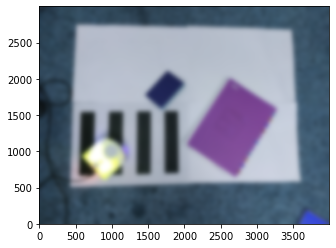

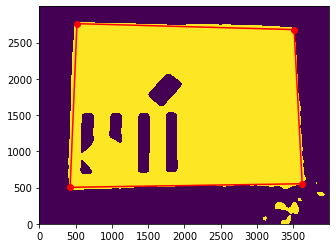

In [1]:
import cv2
import math
from math import cos, sin, degrees, radians
import numpy as np
import matplotlib.pyplot as plt
import MTM
from MTM import matchTemplates, drawBoxesOnRGB
from scipy import ndimage, misc

img = cv2.imread('images/terrain3.jpg')[::-1,:,:]
kernel_size = 201
blurred_img = cv2.GaussianBlur(img,(kernel_size,kernel_size),0)

(b, g, r) = cv2.split(blurred_img)
_,threshold = cv2.threshold(b, 70, 255,  
                            cv2.THRESH_BINARY) 

plt.imshow(blurred_img, origin='lower')
plt.figure()
plt.imshow(threshold, origin='lower')

# Detecting shapes in image by selecting region  
# with same colors or intensity.
contours,_=cv2.findContours(threshold, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 

board = None

# Searching through every region selected to  
# find the required polygon.
for cnt in contours : 
    area = cv2.contourArea(cnt) 

    # Shortlisting the regions based on there area. 
    if area > 500000:  
        approx = cv2.approxPolyDP(cnt,  
                                  0.015
                                  * cv2.arcLength(cnt, True), True) 
        if len(approx) == 4:
            board = approx

n= len(board)
for i in range(n):
    vertice1 = board[i][0]
    vertice2 = board[(i+1)%n][0]
    plt.scatter(vertice1[0], vertice1[1], c='r')
    plt.plot((vertice1[0], vertice2[0]), (vertice1[1], vertice2[1]), 'r')
   

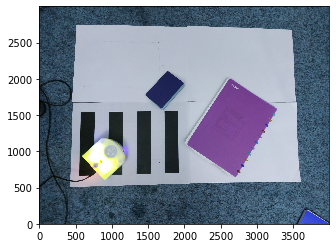

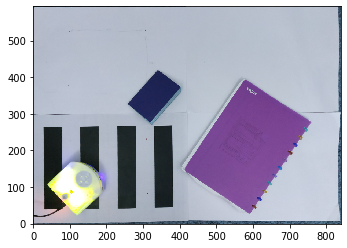

In [2]:
pts0 = np.float32(board)

W, H = 420*2, 297*2
# Define corresponding points in output image
pts1 = np.float32([[0,0],[0,H],[W,H],[W,0]])

# Get perspective transform and apply it
M = cv2.getPerspectiveTransform(pts0,pts1)
rescaled_img = cv2.warpPerspective(img,M,(W,H))

# Save reult
plt.imshow(img, origin='lower')
plt.figure()
plt.imshow(rescaled_img, origin='lower')

# locate thymio and goal

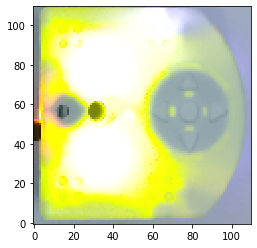

In [3]:
template_1 = cv2.resize(cv2.imread('images/thymio.jpg')[::-1,:,:], dsize=(110, 110), interpolation=cv2.INTER_CUBIC)
plt.imshow(template_1, origin='lower')

In [4]:
### Find the thymio
best_angle = 0
best = 0
best_Hit = []
for angle in np.arange(0, 359, 360/16):
    rotated = ndimage.rotate(template_1, angle) 
    name = "".join(["thymio_", str(angle)])
    listTemplate = [(name, rotated)]
    Hit = matchTemplates(listTemplate, rescaled_img,method=cv2.TM_CCOEFF_NORMED, N_object=1,score_threshold=0.1, maxOverlap=0,searchBox=None)
    if Hit.Score.to_numpy()[0] > best:
        best_Hit = Hit
        best_angle = angle
        best = Hit.Score.to_numpy()[0]

theta = radians(best_angle)
print(theta)

5.497787143782138


In [5]:
print(best_Hit)

   TemplateName                BBox     Score
0  thymio_315.0  (38, 27, 156, 156)  0.721017


(101.85786437626905, 90.85786437626905, -5.497787143782138)


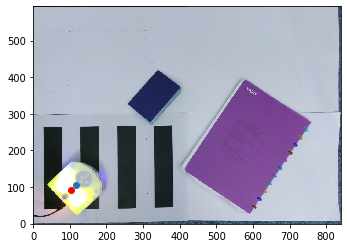

In [6]:
plt.imshow(rescaled_img, origin='lower')
corner = best_Hit.BBox.to_numpy()[0][0:2]
size = best_Hit.BBox.to_numpy()[0][2:4]
center = np.array(corner) + np.array(size)/2
plt.scatter(center[0], center[1])

forward = np.array([-cos(theta), sin(theta)])
wheel_center = center + forward*20
plt.scatter(wheel_center[0], wheel_center[1], c='r')

thymio_pos = (wheel_center[0], wheel_center[1] , -theta)
print(thymio_pos)

# Generate obstacle  map

remove black in background

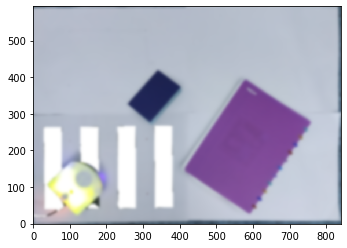

In [7]:
filtered_img = cv2.bilateralFilter(rescaled_img,15, 75, 75)
black_min = np.array([0, 0, 0])
black_max = np.array([50, 50, 50])

mask=cv2.inRange(filtered_img,black_min,black_max)
plt.imshow(filtered_img)

filtered_img[mask>0]=(255,255,255)

kernel_size = 21
filtered_img = cv2.GaussianBlur(filtered_img,(kernel_size,kernel_size),0)

plt.imshow(filtered_img, origin='lower')

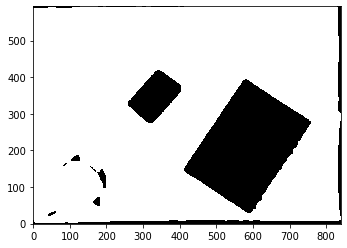

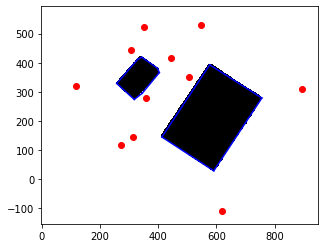

In [8]:
### Image processing filter

threshold_val = 150

### Find the thymio and the destination
(b, g, r) = cv2.split(filtered_img)
ret2, thresh2 = cv2.threshold(b, threshold_val, 255, cv2.THRESH_BINARY_INV)
ret3, thresh3 = cv2.threshold(g, threshold_val, 255, cv2.THRESH_BINARY_INV)
ret4, thresh4 = cv2.threshold(r, threshold_val, 255, cv2.THRESH_BINARY_INV)
bgr_thresh = cv2.merge((thresh2, thresh3, thresh4))

black_and_white = thresh3

plt.imshow(black_and_white, cmap='Greys', origin='lower')

# Detecting shapes in image by selecting region  
# with same colors or intensity. 
contours,_=cv2.findContours(black_and_white, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 

obstacles =  []

# Searching through every region selected to  
# find the required polygon. 
for cnt in contours : 
    area = cv2.contourArea(cnt) 
   
    # Shortlisting the regions based on there area. 
    if area > 8000:  
        approx = cv2.approxPolyDP(cnt,  
                                  0.01 * cv2.arcLength(cnt, True), True) 
        obstacles.append(approx)
    else:
        cv2.drawContours(black_and_white, [cnt], -1, 0, thickness=-1)
    
plt.figure()

plt.imshow(black_and_white, cmap='Greys', origin='lower')

obstacle_map = black_and_white

from numpy import sqrt
def norm(vec):
    return sqrt(vec[0]**2 + vec[1]**2)

MARGIN = 100

way_points = []

for obstacle in obstacles:
    n= len(obstacle)
    for i in range(n):
        vertice1 = obstacle[i][0]
        vertice2 = obstacle[(i+1)%n][0]
        vertice3 = obstacle[(i+2)%n][0]
        
        vec1 = vertice2 - vertice1
        vec2 = vertice2 - vertice3
        
        normal_vec = vec1/norm(vec1) + vec2/norm(vec2)
        way_point = vertice2 + normal_vec*MARGIN
        
        way_points.append(way_point)
        
        plt.scatter(way_point[0], way_point[1], c='r')
        plt.plot((vertice1[0], vertice2[0]), (vertice1[1], vertice2[1]), 'b')

# Generate Graph

In [9]:
import itertools
class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.gScore = np.inf
        self.fScore = np.inf
        self.neighbours = []
    def plot(self, color = 'r'):
        plt.scatter(self.x, self.y, c=color)
    def get_pos(self):
        return self.x, self.y
    def __repr__(self):
        return "node ("+str(self.x)+","+str(self.y)+")"
#     def __eq__(self, other):
#         return self.x == other.x and self.y == other.y
#     def __hash__(self):
#         return hash((self.x, self.y))
    
def sample_image(obstacle_map, x, y):
    max_y = obstacle_map.shape[0]
    max_x = obstacle_map.shape[1]
    if x >= max_x or x < 0 or y >= max_y or y < 0:
        return 0
    else:
        return obstacle_map[y][x]

def noObstacleBetween(p1, p2):
    RESOLUTION = 50
    
    x, y = p1
    x_end, y_end = p2
    forward = np.array([x_end - x, y_end - y])
    
    dist = np.linalg.norm(forward)
    if dist == 0:
        return False
    
    forward = forward/dist
    perp = np.array([forward[1], -forward[0]])
    
    for perp_dist in np.arange(-MARGIN*0.9, MARGIN*0.9, RESOLUTION):
        for forward_dist in np.arange(-MARGIN, dist+MARGIN, RESOLUTION):
            sample_point = np.array(p1) + forward_dist*forward + perp_dist*perp
#             plt.scatter(sample_point[0], sample_point[1], c='g')
            intensity = sample_image(obstacle_map, int(sample_point[0]), int(sample_point[1]))
            if intensity == 255:
                return False
    return True

class Graph:
    def __init__(self, way_points):
        self.nodes = []
        for way_point in way_points:
            x, y = way_point
            self.nodes.append(Node(x, y))
        for node1, node2 in itertools.combinations(self.nodes, 2):
            if noObstacleBetween(node1.get_pos(), node2.get_pos()):
                node1.neighbours.append(node2)
                node2.neighbours.append(node1)

                x, y = node1.get_pos()
                x_end, y_end = node2.get_pos()
                plt.plot((x, x_end), (y, y_end), 'm', linewidth=1)
                
    def add_new_node(self, node):
        for potential_neighbour in self.nodes:
            if noObstacleBetween(node.get_pos(), potential_neighbour.get_pos()):
                node.neighbours.append(potential_neighbour)
                potential_neighbour.neighbours.append(node)
                
#                 x, y = node.get_pos()
#                 x_end, y_end = potential_neighbour.get_pos()
#                 plt.plot((x, x_end), (y, y_end), 'm', linewidth=1)
        self.nodes.append(node)
        
# plt.imshow(obstacle_map, cmap='Greys')
# noObstacleBetween((10, 10), (1000, 2000))

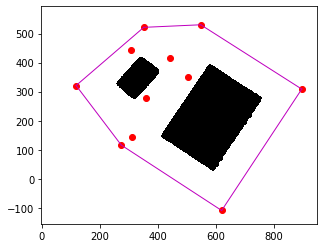

In [10]:
plt.imshow(obstacle_map, cmap='Greys', origin='lower')

graph = Graph(way_points)

for node in graph.nodes:
    node.plot()

# Path finding (A*)

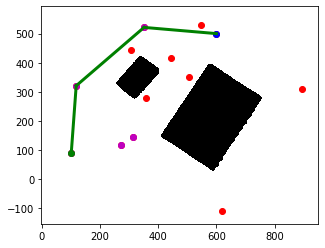

In [11]:
def distance(node1, node2):
    return sqrt((node1.x-node2.x)**2 + (node1.y - node2.y)**2)

### path computation

def A_Star(start, goal, h):
    for node in graph.nodes:
        node.gScore = np.inf
        node.fScore = np.inf
    
    openSet = [start]
    start.gScore = 0
    closedSet = []
    
    cameFrom = dict()
    
    while openSet != []:
        current = min(openSet, key=lambda node: node.fScore)
        if current == goal:
            path = [current]
            while current in cameFrom.keys():
                path.insert(0, cameFrom[current]) 
                current=cameFrom[current]
            return path, closedSet
        
        openSet.remove(current)
        closedSet.append(current)
        
        for neighbour in current.neighbours:
            if neighbour in closedSet:
                continue
                
            tentative_gScore = current.gScore + distance(current, neighbour)
            
            if neighbour not in openSet:
                openSet.append(neighbour)
            
            if tentative_gScore < neighbour.gScore:
                cameFrom[neighbour] = current
                neighbour.gScore = tentative_gScore
                neighbour.fScore = neighbour.gScore + h(neighbour)
    print("No path found to goal")
    return None, closedSet

def compute_path(start, goal, graph):
    graph.add_new_node(start)
    graph.add_new_node(goal)
    
    h = lambda node: distance(node, goal)
    path_nodes, closedSet = A_Star(start, goal, h)
    
    path = []
    for node in path_nodes:
        x, y = node.get_pos()
        path.append((x, y, 0))
    
    # draw
    for node in graph.nodes:
        node.plot()
    for node in closedSet:
        node.plot('m')
    if path!=None:
        for i in range(len(path_nodes)-1):
            x, y = path_nodes[i].get_pos()
            x_end, y_end = path_nodes[i+1].get_pos()
            plt.plot((x, x_end), (y, y_end), 'g', linewidth=3)
    start.plot('g')
    goal.plot('b')
    
    return path


plt.imshow(obstacle_map, cmap='Greys', origin='lower')

start = Node(thymio_pos[0], thymio_pos[1])
goal = Node(600, 500)

path = compute_path(start, goal, graph)

# Main code

In [ ]:
%run -i "main.py"